# **Notebook 2: Meta-Optimization & Algorithm Tuning**
This notebook focuses on Step 3 of the project: optimizing the metaheuristic optimizers themselves. We use the (Grey Wolf Optimizer) (GWO) as a **Meta-Optimizer** to find the best internal parameters for PSO (Particle Swarm Optimization) and Firefly Algorithm.

## **Imports and Setup**

In [2]:
import pandas as pd
import os
import numpy as np
import random
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import math
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
from collections import Counter
import re

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mixed precision setup
USE_AMP = torch.cuda.is_available()
scaler = GradScaler() if USE_AMP else None

print(f"Using device: {DEVICE}")
print(f"Using mixed precision (AMP): {USE_AMP}")


Using device: cuda
Using mixed precision (AMP): True


C:\Users\Mohammed Hassan\AppData\Local\Temp\ipykernel_32564\3874196551.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if USE_AMP else None


In [3]:
import csv
df = pd.read_csv("IMDB Dataset.csv", sep=",", quotechar='"', quoting=csv.QUOTE_MINIMAL, escapechar="\\", engine="python")
print(df.head())
print(df["sentiment"].value_counts())
print("Total samples:", len(df))


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Total samples: 50000


In [4]:
# Encode labels FIRST
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

# Stratified sampling: exactly 10k (5k per class)
df_sampled = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(n=5000, random_state=SEED)
).reset_index(drop=True)

df = df_sampled

print("Final dataset size:", len(df))
print(df["label"].value_counts())

Final dataset size: 10000
label
0    5000
1    5000
Name: count, dtype: int64


C:\Users\Mohammed Hassan\AppData\Local\Temp\ipykernel_32564\3039554225.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("label", group_keys=False).apply(


In [5]:
X = df["review"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")


Train: 8000
Validation: 1000
Test: 1000


In [6]:
MAX_VOCAB = 30000
MAX_LEN = 150

# Pure PyTorch Tokenizer (no TensorFlow dependency)
class SimpleTokenizer:
    def __init__(self, num_words=None, oov_token="<OOV>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {}
        self.index_word = {}
        
    def fit_on_texts(self, texts):
        word_counts = Counter()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            word_counts.update(words)
        
        # Reserve 0 for padding, 1 for OOV
        self.word_index[self.oov_token] = 1
        self.index_word[1] = self.oov_token
        
        # Add most common words
        for idx, (word, _) in enumerate(word_counts.most_common(self.num_words - 2), start=2):
            self.word_index[word] = idx
            self.index_word[idx] = word
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            seq = [self.word_index.get(w, 1) for w in words]  # 1 = OOV
            sequences.append(seq)
        return sequences

def pad_sequences(sequences, maxlen, padding='post', truncating='post', value=0):
    result = np.full((len(sequences), maxlen), value, dtype=np.int64)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            if truncating == 'post':
                result[i] = seq[:maxlen]
            else:
                result[i] = seq[-maxlen:]
        else:
            if padding == 'post':
                result[i, :len(seq)] = seq
            else:
                result[i, -len(seq):] = seq
    return result

tokenizer = SimpleTokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def encode(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

X_train_seq = encode(X_train)
X_val_seq = encode(X_val)
X_test_seq = encode(X_test)

# # Create 25% TUNING SUBSET for meta-optimization (was 15%)
# np.random.seed(SEED)
# tune_size = int(len(X_train_seq) * 0.25)
# tune_indices = np.random.choice(len(X_train_seq), tune_size, replace=False)
# X_tune_seq = X_train_seq[tune_indices]
# y_tune = y_train[tune_indices]
# print(f"Tuning subset size: {len(X_tune_seq)} (25% of training)")

# Use FULL training set for meta-optimization (100%)
np.random.seed(SEED)
X_tune_seq = X_train_seq  # Use all training data
y_tune = y_train
print(f"Tuning subset size: {len(X_tune_seq)} (100% of training)")

Tuning subset size: 8000 (100% of training)


In [7]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## **Model Definition**

In [8]:
class TextBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(TextBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=n_layers,
            bidirectional=True, dropout=dropout if n_layers > 1 else 0, batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)


In [9]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3, save_best=False):
    global scaler, USE_AMP
    history = {"train_loss": [], "val_loss": [], "val_accuracy": []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            
            if USE_AMP:
                with torch.amp.autocast('cuda'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        preds, trues = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                if USE_AMP:
                    with torch.amp.autocast('cuda'):
                        outputs = model(x)
                        loss = criterion(outputs, y)
                else:
                    outputs = model(x)
                    loss = criterion(outputs, y)
                val_loss += loss.item()
                preds.extend(outputs.argmax(1).cpu().numpy())
                trues.extend(y.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(trues, preds)
        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(acc)

        # Save best model
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        remaining = epochs - epoch - 1
        print(f"[{epoch+1}/{epochs}] Train={avg_train_loss:.4f} Val={avg_val_loss:.4f} Acc={acc:.4f} | {remaining} left")

    if save_best and best_model_state is not None:
        return history, best_model_state
    return history

In [10]:
bilstm_param_bounds = [
    (64, 256),      # hidden_dim 
    (0.2, 0.6),     # dropout
    (1e-4, 5e-3),   # learning rate
]
FIXED_EMBED_DIM = 128
BATCH_SIZE = 64 

In [11]:
def params_to_dict(params_array):
    return {
        "embed_dim": FIXED_EMBED_DIM,
        "hidden_dim": int(np.clip(params_array[0], 64, 256)),  # Ensure constrained
        "dropout": float(params_array[1]),
        "lr": float(params_array[2]),
        "batch_size": BATCH_SIZE
    }


In [12]:
def quick_evaluate_bilstm(params_array):
    model_params = params_to_dict(params_array)

    # Use TUNING SUBSET (15%) for meta-optimization
    train_ds = IMDBDataset(X_tune_seq, y_tune)
    val_ds = IMDBDataset(X_val_seq, y_val)

    # Windows compatible: num_workers=0 avoids multiprocessing issues
    train_loader = DataLoader(train_ds, batch_size=model_params["batch_size"], shuffle=True,
                              num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=model_params["batch_size"], shuffle=False,
                            num_workers=0, pin_memory=True)

    model = TextBiLSTM(
        vocab_size=MAX_VOCAB, embed_dim=model_params["embed_dim"],
        hidden_dim=model_params["hidden_dim"], output_dim=2, n_layers=1,
        dropout=model_params["dropout"]
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_params["lr"])
    criterion = nn.CrossEntropyLoss()

    # Quick eval: exactly 3 epochs
    history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3)
    best_val_acc = max(history["val_accuracy"])
    return best_val_acc


# **Optimizing the Optimizer (Meta-Optimization)**

## **Define Algorithms**

### **Grey Wolf Optimizer (GWO)**

In [13]:
class GreyWolfOptimizer:
    def __init__(self, n_wolves=4, max_iter=5, a_param=2):
        self.n_wolves = n_wolves
        self.max_iter = max_iter
        self.a_param = a_param
        self.convergence_history = []

    def optimize(self, param_bounds, obj_func):
        n_params = len(param_bounds)
        positions = np.random.uniform(
            [b[0] for b in param_bounds], [b[1] for b in param_bounds], (self.n_wolves, n_params)
        )

        alpha_pos, alpha_score = np.zeros(n_params), -np.inf
        beta_pos, beta_score = np.zeros(n_params), -np.inf
        delta_pos, delta_score = np.zeros(n_params), -np.inf

        for iteration in range(self.max_iter):
            for i in range(self.n_wolves):
                positions[i] = np.clip(positions[i], [b[0] for b in param_bounds], [b[1] for b in param_bounds])
                fitness = obj_func(positions[i])

                if fitness > alpha_score:
                    alpha_score, alpha_pos = fitness, positions[i].copy()
                elif fitness > beta_score:
                    beta_score, beta_pos = fitness, positions[i].copy()
                elif fitness > delta_score:
                    delta_score, delta_pos = fitness, positions[i].copy()

            a = self.a_param - iteration * (self.a_param / self.max_iter)

            for i in range(self.n_wolves):
                for j in range(n_params):
                    r1, r2 = np.random.random(2), np.random.random(2)
                    A1, C1 = 2*a*r1[0]-a, 2*r2[0]
                    X1 = alpha_pos[j] - A1 * abs(C1*alpha_pos[j] - positions[i,j])
                    A2, C2 = 2*a*r1[1]-a, 2*r2[1]
                    X2 = beta_pos[j] - A2 * abs(C2*beta_pos[j] - positions[i,j])
                    A3, C3 = 2*a*np.random.random()-a, 2*np.random.random()
                    X3 = delta_pos[j] - A3 * abs(C3*delta_pos[j] - positions[i,j])
                    positions[i,j] = (X1 + X2 + X3) / 3

            self.convergence_history.append(alpha_score)
            print(f"GWO Iter {iteration+1}/{self.max_iter}: Best={alpha_score:.4f}")

        return alpha_pos, alpha_score

### **Particle Swarm Optimization (PSO)**

In [14]:
class ParticleSwarmOptimization:
    def __init__(self, n_particles=4, n_iterations=5, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w, self.c1, self.c2 = w, c1, c2
        self.convergence_history = []

    def optimize_hyperparameters(self, param_bounds, objective_function):
        n_params = len(param_bounds)
        positions = np.random.uniform(
            [b[0] for b in param_bounds], [b[1] for b in param_bounds], (self.n_particles, n_params)
        )
        velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_params))

        personal_best_positions = positions.copy()
        personal_best_scores = np.array([objective_function(p) for p in positions])
        global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
        global_best_score = np.max(personal_best_scores)
        self.convergence_history.append(global_best_score)

        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] = (self.w * velocities[i] +
                               self.c1 * r1 * (personal_best_positions[i] - positions[i]) +
                               self.c2 * r2 * (global_best_position - positions[i]))
                positions[i] += velocities[i]
                positions[i] = np.clip(positions[i], [b[0] for b in param_bounds], [b[1] for b in param_bounds])
                
                score = objective_function(positions[i])
                if score > personal_best_scores[i]:
                    personal_best_scores[i] = score
                    personal_best_positions[i] = positions[i].copy()
                if score > global_best_score:
                    global_best_score = score
                    global_best_position = positions[i].copy()

            self.convergence_history.append(global_best_score)
            print(f"PSO Iter {iteration+1}/{self.n_iterations}: Best={global_best_score:.4f}")

        return global_best_position, global_best_score


### **Firefly Algorithm**

In [15]:
class FireflyAlgorithm:
    def __init__(self, n_fireflies=4, max_iter=5, alpha=0.25, beta0=1.0, gamma=1.0):
        self.n_fireflies = n_fireflies
        self.max_iter = max_iter
        self.alpha, self.beta0, self.gamma = alpha, beta0, gamma
        self.convergence_history = []

    def _attractiveness(self, r):
        return self.beta0 * np.exp(-self.gamma * r * r)

    def _distance(self, xi, xj):
        return np.sqrt(np.sum((xi - xj) ** 2))

    def optimize_hyperparameters(self, param_bounds, objective_function):
        n_params = len(param_bounds)
        positions = np.random.uniform(
            [b[0] for b in param_bounds], [b[1] for b in param_bounds], (self.n_fireflies, n_params)
        )

        fitness = np.array([objective_function(pos) for pos in positions])
        best_idx = np.argmax(fitness)
        best_fitness = fitness[best_idx]
        best_position = positions[best_idx].copy()
        self.convergence_history.append(best_fitness)
        print(f"FA Initial best: {best_fitness:.4f}")

        for iteration in range(self.max_iter):
            alpha_t = self.alpha * (0.95 ** iteration)
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if fitness[j] > fitness[i]:
                        r_ij = self._distance(positions[i], positions[j])
                        beta = self._attractiveness(r_ij)
                        epsilon = np.random.uniform(-0.5, 0.5, n_params)
                        positions[i] = positions[i] + beta * (positions[j] - positions[i]) + alpha_t * epsilon
                        positions[i] = np.clip(positions[i], [b[0] for b in param_bounds], [b[1] for b in param_bounds])
                        fitness[i] = objective_function(positions[i])
                        if fitness[i] > best_fitness:
                            best_fitness = fitness[i]
                            best_position = positions[i].copy()

            self.convergence_history.append(best_fitness)
            print(f"FA Iter {iteration+1}/{self.max_iter}: Best={best_fitness:.4f}")

        return best_position, best_fitness


## **Tuning PSO with GWO**

In [16]:
pso_param_bounds = [
    (0.4, 0.9),   # inertia weight (w)
    (0.5, 2.5),   # cognitive (c1)
    (0.5, 2.5)    # social (c2)
]


In [17]:
def create_pso_objective(n_particles=4, n_iterations=5):
    def pso_objective(pso_params):
        w, c1, c2 = pso_params
        pso = ParticleSwarmOptimization(n_particles=n_particles, n_iterations=n_iterations, w=w, c1=c1, c2=c2)
        _, best_score = pso.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
        return best_score
    return pso_objective

pso_obj_func = create_pso_objective(n_particles=4, n_iterations=5)

print("Starting GWO optimization of PSO...")
gwo_for_pso = GreyWolfOptimizer(n_wolves=4, max_iter=5, a_param=2) 

start_time = time.time()
best_pso_params, best_pso_score = gwo_for_pso.optimize(pso_param_bounds, pso_obj_func)
pso_tuning_time = time.time() - start_time

print(f"\nPSO TUNING RESULTS")
print(f"  w: {best_pso_params[0]:.4f}")
print(f"  c1: {best_pso_params[1]:.4f}")
print(f"  c2: {best_pso_params[2]:.4f}")
print(f"  Best Accuracy: {best_pso_score:.4f}")
print(f"  Time: {pso_tuning_time:.2f}s")

Starting GWO optimization of PSO...
[1/3] Train=0.6747 Val=0.6303 Acc=0.6470 | 2 left
[2/3] Train=0.5772 Val=0.5964 Acc=0.6770 | 1 left
[3/3] Train=0.4866 Val=0.5454 Acc=0.7320 | 0 left
[1/3] Train=0.6818 Val=0.6795 Acc=0.5520 | 2 left
[2/3] Train=0.5654 Val=0.5922 Acc=0.6980 | 1 left
[3/3] Train=0.3654 Val=0.5601 Acc=0.7430 | 0 left
[1/3] Train=0.6773 Val=0.6225 Acc=0.6530 | 2 left
[2/3] Train=0.5395 Val=0.5647 Acc=0.7110 | 1 left
[3/3] Train=0.3270 Val=0.5670 Acc=0.7620 | 0 left
[1/3] Train=0.6779 Val=0.6427 Acc=0.6260 | 2 left
[2/3] Train=0.5599 Val=0.5835 Acc=0.6970 | 1 left
[3/3] Train=0.3857 Val=0.5804 Acc=0.7390 | 0 left
[1/3] Train=0.6930 Val=0.6882 Acc=0.5390 | 2 left
[2/3] Train=0.6864 Val=0.6829 Acc=0.5710 | 1 left
[3/3] Train=0.6765 Val=0.6765 Acc=0.5810 | 0 left
[1/3] Train=0.6928 Val=0.6880 Acc=0.5460 | 2 left
[2/3] Train=0.6862 Val=0.6838 Acc=0.5690 | 1 left
[3/3] Train=0.6791 Val=0.6778 Acc=0.5870 | 0 left
[1/3] Train=0.6947 Val=0.6898 Acc=0.5130 | 2 left
[2/3] Train=0.

## **Tuning Firefly with GWO**

In [18]:
fa_param_bounds = [
    (0.2, 2.0),   # beta_0
    (0.1, 2.0),   # gamma
    (0.2, 1.0)    # alpha
]

In [19]:
def create_firefly_objective(n_fireflies=4, max_iter=5):
    def firefly_objective(fa_params):
        beta0, gamma, alpha = fa_params
        fa = FireflyAlgorithm(n_fireflies=n_fireflies, max_iter=max_iter, alpha=alpha, beta0=beta0, gamma=gamma)
        _, best_score = fa.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
        return best_score
    return firefly_objective

fa_obj_func = create_firefly_objective(n_fireflies=4, max_iter=5)

print("Starting GWO optimization of Firefly...")
gwo_for_fa = GreyWolfOptimizer(n_wolves=4, max_iter=5, a_param=2)

start_time = time.time()
best_fa_params, best_fa_score = gwo_for_fa.optimize(fa_param_bounds, fa_obj_func)
fa_tuning_time = time.time() - start_time

print(f"\nFIREFLY TUNING RESULTS")
print(f"  beta0: {best_fa_params[0]:.4f}")
print(f"  gamma: {best_fa_params[1]:.4f}")
print(f"  alpha: {best_fa_params[2]:.4f}")
print(f"  Best Accuracy: {best_fa_score:.4f}")
print(f"  Time: {fa_tuning_time:.2f}s")

Starting GWO optimization of Firefly...
[1/3] Train=0.6824 Val=0.6551 Acc=0.6160 | 2 left
[2/3] Train=0.6190 Val=0.6205 Acc=0.6520 | 1 left
[3/3] Train=0.5120 Val=0.9056 Acc=0.5450 | 0 left
[1/3] Train=0.6819 Val=0.6501 Acc=0.6200 | 2 left
[2/3] Train=0.5430 Val=0.5754 Acc=0.6960 | 1 left
[3/3] Train=0.2972 Val=0.5964 Acc=0.7400 | 0 left
[1/3] Train=0.6873 Val=0.6370 Acc=0.6460 | 2 left
[2/3] Train=0.5871 Val=0.6080 Acc=0.6570 | 1 left
[3/3] Train=0.4178 Val=0.5399 Acc=0.7400 | 0 left
[1/3] Train=0.6729 Val=0.6025 Acc=0.6950 | 2 left
[2/3] Train=0.6074 Val=0.6515 Acc=0.6240 | 1 left
[3/3] Train=0.5103 Val=0.5720 Acc=0.7180 | 0 left
FA Initial best: 0.7400
[1/3] Train=0.6941 Val=0.6873 Acc=0.5410 | 2 left
[2/3] Train=0.6852 Val=0.6821 Acc=0.5550 | 1 left
[3/3] Train=0.6724 Val=0.6626 Acc=0.6000 | 0 left
[1/3] Train=0.6910 Val=0.6508 Acc=0.6240 | 2 left
[2/3] Train=0.5666 Val=0.6616 Acc=0.6550 | 1 left
[3/3] Train=0.3250 Val=0.5878 Acc=0.7510 | 0 left
[1/3] Train=0.6921 Val=0.6875 Acc=0.

## **Comparative Analysis**

In [20]:
# Default PSO
default_pso = ParticleSwarmOptimization(n_particles=2, n_iterations=3, w=0.7, c1=1.5, c2=1.5)
_, default_pso_score = default_pso.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)

# Optimized PSO
optimized_pso = ParticleSwarmOptimization(n_particles=2, n_iterations=3,
    w=best_pso_params[0], c1=best_pso_params[1], c2=best_pso_params[2])
_, optimized_pso_score = optimized_pso.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)

pso_delta = optimized_pso_score - default_pso_score
print(f"PSO: Default={default_pso_score:.4f}, Optimized={optimized_pso_score:.4f}, Delta={pso_delta:+.4f}")

# Default Firefly
default_fa = FireflyAlgorithm(n_fireflies=2, max_iter=3, alpha=0.25, beta0=1.0, gamma=1.0)
_, default_fa_score = default_fa.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)

fa_delta = best_fa_score - default_fa_score
print(f"Firefly: Default={default_fa_score:.4f}, Optimized={best_fa_score:.4f}, Delta={fa_delta:+.4f}")

[1/3] Train=0.6948 Val=0.6874 Acc=0.5530 | 2 left
[2/3] Train=0.6835 Val=0.6779 Acc=0.5900 | 1 left
[3/3] Train=0.6643 Val=0.6568 Acc=0.5880 | 0 left
[1/3] Train=0.6759 Val=0.6423 Acc=0.6020 | 2 left
[2/3] Train=0.5502 Val=0.5608 Acc=0.7280 | 1 left
[3/3] Train=0.3434 Val=0.5506 Acc=0.7460 | 0 left
[1/3] Train=0.6679 Val=0.6000 Acc=0.6850 | 2 left
[2/3] Train=0.4932 Val=0.5349 Acc=0.7260 | 1 left
[3/3] Train=0.2274 Val=0.6561 Acc=0.7330 | 0 left
[1/3] Train=0.6932 Val=0.6921 Acc=0.5360 | 2 left
[2/3] Train=0.6866 Val=0.6868 Acc=0.5600 | 1 left
[3/3] Train=0.6799 Val=0.6815 Acc=0.5860 | 0 left
PSO Iter 1/3: Best=0.7460
[1/3] Train=0.6830 Val=0.6931 Acc=0.5410 | 2 left
[2/3] Train=0.6016 Val=0.5035 Acc=0.7560 | 1 left
[3/3] Train=0.3379 Val=0.4826 Acc=0.8030 | 0 left
[1/3] Train=0.6935 Val=0.6903 Acc=0.5150 | 2 left
[2/3] Train=0.6865 Val=0.6852 Acc=0.5420 | 1 left
[3/3] Train=0.6783 Val=0.6784 Acc=0.5740 | 0 left
PSO Iter 2/3: Best=0.8030
[1/3] Train=0.6696 Val=0.6052 Acc=0.6770 | 2 lef

## **Stability Analysis (5 Runs)**

In [21]:
print("\nStability Analysis: Running 15 trials for each optimizer...")
stability_results = {"PSO_default": [], "PSO_optimized": [], "FA_default": [], "FA_optimized": []}

for run in range(15):
    print(f"\n--- Stability Run {run+1}/15 ---")
    
    # Default PSO
    pso_def = ParticleSwarmOptimization(n_particles=2, n_iterations=3, w=0.7, c1=1.5, c2=1.5)
    _, score = pso_def.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
    stability_results["PSO_default"].append(score)
    
    # Optimized PSO
    pso_opt = ParticleSwarmOptimization(n_particles=2, n_iterations=3,
        w=best_pso_params[0], c1=best_pso_params[1], c2=best_pso_params[2])
    _, score = pso_opt.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
    stability_results["PSO_optimized"].append(score)
    
    # Default FA
    fa_def = FireflyAlgorithm(n_fireflies=2, max_iter=3, alpha=0.25, beta0=1.0, gamma=1.0)
    _, score = fa_def.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
    stability_results["FA_default"].append(score)
    
    # Optimized FA
    fa_opt = FireflyAlgorithm(n_fireflies=2, max_iter=3,
        alpha=best_fa_params[2], beta0=best_fa_params[0], gamma=best_fa_params[1])
    _, score = fa_opt.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
    stability_results["FA_optimized"].append(score)

print("\nStability Summary:")
for key, values in stability_results.items():
    print(f"  {key}: mean={np.mean(values):.4f}, std={np.std(values):.4f}")


Stability Analysis: Running 15 trials for each optimizer...

--- Stability Run 1/15 ---
[1/3] Train=0.6816 Val=0.6483 Acc=0.6240 | 2 left
[2/3] Train=0.6008 Val=0.5981 Acc=0.6850 | 1 left
[3/3] Train=0.4769 Val=0.5903 Acc=0.7190 | 0 left
[1/3] Train=0.6893 Val=0.6726 Acc=0.5820 | 2 left
[2/3] Train=0.6252 Val=0.5857 Acc=0.6740 | 1 left
[3/3] Train=0.5308 Val=0.5396 Acc=0.7210 | 0 left
[1/3] Train=0.6819 Val=0.6318 Acc=0.6320 | 2 left
[2/3] Train=0.5233 Val=0.5659 Acc=0.7310 | 1 left
[3/3] Train=0.3248 Val=0.5812 Acc=0.7300 | 0 left
[1/3] Train=0.6936 Val=0.6913 Acc=0.5370 | 2 left
[2/3] Train=0.6871 Val=0.6872 Acc=0.5460 | 1 left
[3/3] Train=0.6797 Val=0.6813 Acc=0.5790 | 0 left
PSO Iter 1/3: Best=0.7310
[1/3] Train=0.6844 Val=0.6534 Acc=0.6090 | 2 left
[2/3] Train=0.5390 Val=0.5692 Acc=0.7190 | 1 left
[3/3] Train=0.3198 Val=0.6610 Acc=0.7260 | 0 left
[1/3] Train=0.6920 Val=0.6606 Acc=0.6160 | 2 left
[2/3] Train=0.5715 Val=0.6090 Acc=0.6970 | 1 left
[3/3] Train=0.3356 Val=0.6467 Acc=0

## **Save Results**

In [29]:
import json
os.makedirs("results", exist_ok=True)

# 1. Tuning Comparison CSV
tuning_df = pd.DataFrame({
    "Algorithm": ["PSO", "PSO", "Firefly", "Firefly"],
    "Config": ["Old", "New", "Old", "New"],
    "Param1_w_or_beta0": [0.7, best_pso_params[0], 1.0, best_fa_params[0]],
    "Param2_c1_or_gamma": [1.5, best_pso_params[1], 1.0, best_fa_params[1]],
    "Param3_c2_or_alpha": [1.5, best_pso_params[2], 0.25, best_fa_params[2]],
})
tuning_df.to_csv("results/tuning_comparison.csv", index=False)
print("Saved: results/tuning_comparison.csv")

# 2. Delta Performance CSV
delta_df = pd.DataFrame({
    "Algorithm": ["PSO", "Firefly"],
    "Default_Acc": [default_pso_score, default_fa_score],
    "Optimized_Acc": [optimized_pso_score, best_fa_score],
    "Delta": [pso_delta, fa_delta],
})
delta_df.to_csv("results/delta_performance.csv", index=False)
print("Saved: results/delta_performance.csv")

# 3. Training/Convergence History CSV (with integer iteration column)
pso_hist = gwo_for_pso.convergence_history
fa_hist = gwo_for_fa.convergence_history
max_len_hist = max(len(pso_hist), len(fa_hist))

# Pad shorter list with None
pso_hist_padded = pso_hist + [None] * (max_len_hist - len(pso_hist))
fa_hist_padded = fa_hist + [None] * (max_len_hist - len(fa_hist))

history_df = pd.DataFrame({
    "Iteration": list(range(1, max_len_hist + 1)),  # Integer iterations
    "PSO_GWO_Convergence": pso_hist_padded,
    "FA_GWO_Convergence": fa_hist_padded
})
history_df.to_csv("results/training_history.csv", index=False)
print("Saved: results/training_history.csv")

# 4. Stability Log CSV
stability_df = pd.DataFrame(stability_results)
stability_df["Run"] = list(range(1, 16))
stability_df = stability_df[["Run", "PSO_default", "PSO_optimized", "FA_default", "FA_optimized"]]
stability_df.to_csv("results/stability_log.csv", index=False)
print("Saved: results/stability_log.csv")

print("\nAll results saved!")

Saved: results/tuning_comparison.csv
Saved: results/delta_performance.csv
Saved: results/training_history.csv
Saved: results/stability_log.csv

All results saved!


## **Final Test (Full Dataset)**

In [30]:
print("\n" + "="*50)
print("FINAL TEST (50k dataset)")
print("="*50)

df_full = pd.read_csv("IMDB Dataset.csv")
df_full["label"] = df_full["sentiment"].map({"negative": 0, "positive": 1})
X_full, y_full = df_full["review"].values, df_full["label"].values

X_tr, X_te, y_tr, y_te = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

tok = SimpleTokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(X_tr)
X_tr_seq = pad_sequences(tok.texts_to_sequences(X_tr), maxlen=MAX_LEN)
X_te_seq = pad_sequences(tok.texts_to_sequences(X_te), maxlen=MAX_LEN)

# Optimized PSO model - find best params
pso = ParticleSwarmOptimization(n_particles=2, n_iterations=3,
    w=best_pso_params[0], c1=best_pso_params[1], c2=best_pso_params[2])
pso_p, _ = pso.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
pso_cfg = params_to_dict(pso_p)

print(f"\nTraining PSO model with: hidden_dim={pso_cfg['hidden_dim']}, dropout={pso_cfg['dropout']:.3f}, lr={pso_cfg['lr']:.5f}")

pso_m = TextBiLSTM(MAX_VOCAB, pso_cfg["embed_dim"], pso_cfg["hidden_dim"], 2, 1, pso_cfg["dropout"]).to(DEVICE)
opt = torch.optim.Adam(pso_m.parameters(), lr=pso_cfg["lr"])
criterion = nn.CrossEntropyLoss()

tr_ds = TensorDataset(torch.tensor(X_tr_seq), torch.tensor(y_tr))
te_ds = TensorDataset(torch.tensor(X_te_seq), torch.tensor(y_te))
# Windows compatible: num_workers=0 avoids multiprocessing issues
tr_ld = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
te_ld = DataLoader(te_ds, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

# Final training: 8 epochs with best model saving
print("\nTraining PSO model (8 epochs)...")
pso_history, pso_best_state = train_model(pso_m, tr_ld, te_ld, opt, criterion, epochs=8, save_best=True)
pso_m.load_state_dict(pso_best_state)
torch.save(pso_best_state, "results/best_pso_model.pt")
print("Saved: results/best_pso_model.pt")

pso_m.eval()
preds = []
with torch.no_grad():
    for x, y in te_ld:
        if USE_AMP:
            with autocast():
                preds.extend(pso_m(x.to(DEVICE)).argmax(1).cpu().numpy())
        else:
            preds.extend(pso_m(x.to(DEVICE)).argmax(1).cpu().numpy())
pso_acc = accuracy_score(y_te, preds)
print(f"PSO Test Accuracy: {pso_acc:.4f}")


FINAL TEST (50k dataset)
[1/3] Train=0.6928 Val=0.6813 Acc=0.5610 | 2 left
[2/3] Train=0.6734 Val=0.6678 Acc=0.6030 | 1 left
[3/3] Train=0.6325 Val=0.6076 Acc=0.6600 | 0 left
[1/3] Train=0.6761 Val=0.6553 Acc=0.5800 | 2 left
[2/3] Train=0.5917 Val=0.6065 Acc=0.6580 | 1 left
[3/3] Train=0.4608 Val=0.6193 Acc=0.6830 | 0 left
[1/3] Train=0.6689 Val=0.6291 Acc=0.6480 | 2 left
[2/3] Train=0.5039 Val=0.5809 Acc=0.6980 | 1 left
[3/3] Train=0.2691 Val=0.6633 Acc=0.7310 | 0 left
[1/3] Train=0.6934 Val=0.6891 Acc=0.5380 | 2 left
[2/3] Train=0.6867 Val=0.6851 Acc=0.5660 | 1 left
[3/3] Train=0.6783 Val=0.6801 Acc=0.5730 | 0 left
PSO Iter 1/3: Best=0.7310
[1/3] Train=0.6695 Val=0.6170 Acc=0.6350 | 2 left
[2/3] Train=0.5182 Val=0.5697 Acc=0.7020 | 1 left
[3/3] Train=0.2936 Val=0.5719 Acc=0.7530 | 0 left
[1/3] Train=0.6943 Val=0.6903 Acc=0.5270 | 2 left
[2/3] Train=0.6896 Val=0.6861 Acc=0.5650 | 1 left
[3/3] Train=0.6821 Val=0.6816 Acc=0.5850 | 0 left
PSO Iter 2/3: Best=0.7530
[1/3] Train=0.6767 Val

C:\Users\Mohammed Hassan\AppData\Local\Temp\ipykernel_32564\1664996987.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


PSO Test Accuracy: 0.8585


In [31]:
# Optimized Firefly model
fa = FireflyAlgorithm(n_fireflies=2, max_iter=3,
    alpha=best_fa_params[2], beta0=best_fa_params[0], gamma=best_fa_params[1])
fa_p, _ = fa.optimize_hyperparameters(bilstm_param_bounds, quick_evaluate_bilstm)
fa_cfg = params_to_dict(fa_p)

print(f"\nTraining FA model with: hidden_dim={fa_cfg['hidden_dim']}, dropout={fa_cfg['dropout']:.3f}, lr={fa_cfg['lr']:.5f}")

fa_m = TextBiLSTM(MAX_VOCAB, fa_cfg["embed_dim"], fa_cfg["hidden_dim"], 2, 1, fa_cfg["dropout"]).to(DEVICE)
opt = torch.optim.Adam(fa_m.parameters(), lr=fa_cfg["lr"])

print("\nTraining FA model (8 epochs)...")
fa_history, fa_best_state = train_model(fa_m, tr_ld, te_ld, opt, criterion, epochs=8, save_best=True)
fa_m.load_state_dict(fa_best_state)
torch.save(fa_best_state, "results/best_fa_model.pt")
print("Saved: results/best_fa_model.pt")

fa_m.eval()
preds = []
with torch.no_grad():
    for x, y in te_ld:
        if USE_AMP:
            with autocast():
                preds.extend(fa_m(x.to(DEVICE)).argmax(1).cpu().numpy())
        else:
            preds.extend(fa_m(x.to(DEVICE)).argmax(1).cpu().numpy())
fa_acc = accuracy_score(y_te, preds)
print(f"Firefly Test Accuracy: {fa_acc:.4f}")

winner = "PSO" if pso_acc > fa_acc else "Firefly"
print(f"\nWinner: {winner}")

with open("results/final_test.json", "w") as f:
    json.dump({"pso_acc": pso_acc, "fa_acc": fa_acc, "winner": winner}, f, indent=2)
print("Saved: results/final_test.json")

[1/3] Train=0.6796 Val=0.6221 Acc=0.6620 | 2 left
[2/3] Train=0.5574 Val=0.5777 Acc=0.6880 | 1 left
[3/3] Train=0.3830 Val=0.5478 Acc=0.7270 | 0 left
[1/3] Train=0.7000 Val=0.6627 Acc=0.6010 | 2 left
[2/3] Train=0.5886 Val=0.5618 Acc=0.7070 | 1 left
[3/3] Train=0.3576 Val=0.5682 Acc=0.7530 | 0 left
FA Initial best: 0.7530
[1/3] Train=0.6728 Val=0.6066 Acc=0.6790 | 2 left
[2/3] Train=0.5015 Val=0.6048 Acc=0.6760 | 1 left
[3/3] Train=0.2567 Val=0.5624 Acc=0.7770 | 0 left
[1/3] Train=0.6919 Val=0.6869 Acc=0.5630 | 2 left
[2/3] Train=0.6840 Val=0.6811 Acc=0.5560 | 1 left
[3/3] Train=0.6719 Val=0.6595 Acc=0.6240 | 0 left
FA Iter 1/3: Best=0.7770
[1/3] Train=0.6922 Val=0.6871 Acc=0.5440 | 2 left
[2/3] Train=0.6841 Val=0.6798 Acc=0.5820 | 1 left
[3/3] Train=0.6704 Val=0.6641 Acc=0.5980 | 0 left
FA Iter 2/3: Best=0.7770
[1/3] Train=0.6829 Val=0.5966 Acc=0.6570 | 2 left
[2/3] Train=0.5325 Val=0.5425 Acc=0.7310 | 1 left
[3/3] Train=0.2718 Val=0.5984 Acc=0.7370 | 0 left
FA Iter 3/3: Best=0.7770



C:\Users\Mohammed Hassan\AppData\Local\Temp\ipykernel_32564\1541108205.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Firefly Test Accuracy: 0.8572

Winner: PSO
Saved: results/final_test.json


## **Visualization**

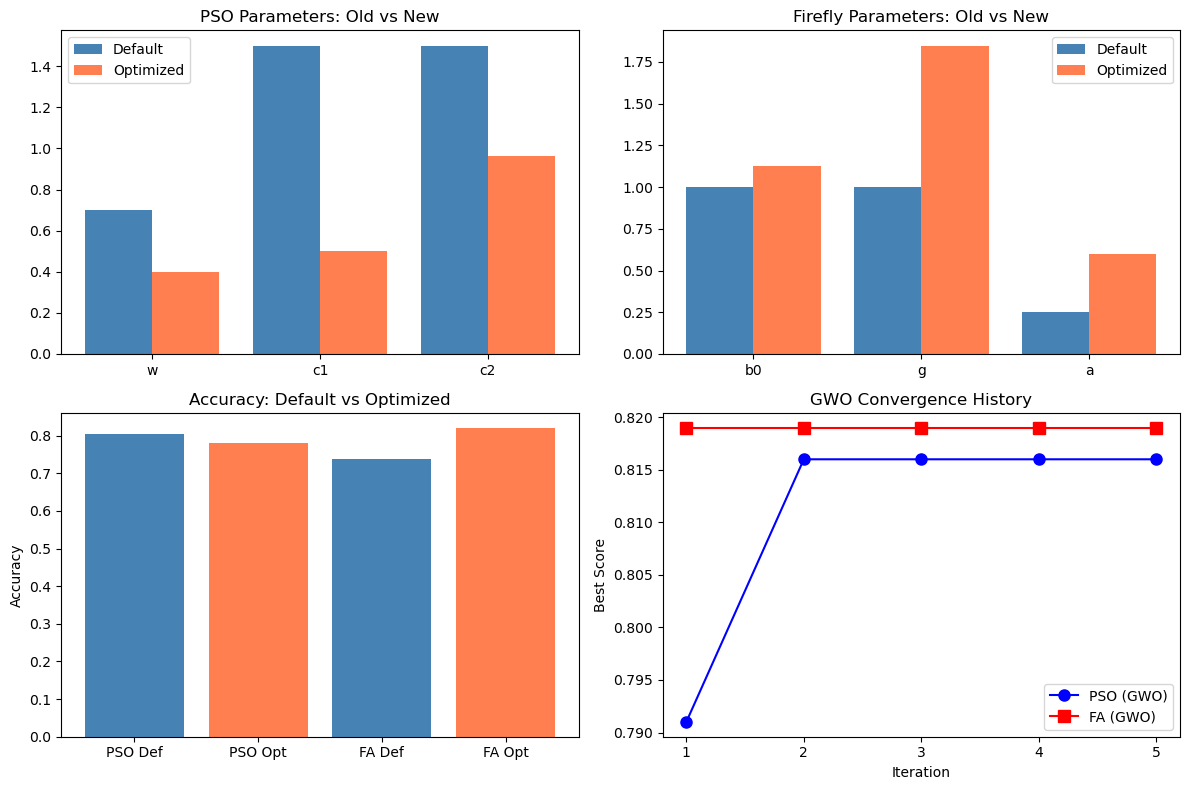

Saved: results/optimization_results.png


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# PSO Params comparison
x = [0, 1, 2]
axes[0,0].bar([i-0.2 for i in x], [0.7, 1.5, 1.5], 0.4, label="Default", color='steelblue')
axes[0,0].bar([i+0.2 for i in x], [best_pso_params[0], best_pso_params[1], best_pso_params[2]], 0.4, label="Optimized", color='coral')
axes[0,0].set_xticks(x); axes[0,0].set_xticklabels(["w", "c1", "c2"])
axes[0,0].set_title("PSO Parameters: Old vs New"); axes[0,0].legend()

# Firefly Params comparison
axes[0,1].bar([i-0.2 for i in x], [1.0, 1.0, 0.25], 0.4, label="Default", color='steelblue')
axes[0,1].bar([i+0.2 for i in x], [best_fa_params[0], best_fa_params[1], best_fa_params[2]], 0.4, label="Optimized", color='coral')
axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(["b0", "g", "a"])
axes[0,1].set_title("Firefly Parameters: Old vs New"); axes[0,1].legend()

# Delta Performance
axes[1,0].bar(["PSO Def", "PSO Opt", "FA Def", "FA Opt"],
    [default_pso_score, optimized_pso_score, default_fa_score, best_fa_score],
    color=['steelblue', 'coral', 'steelblue', 'coral'])
axes[1,0].set_title("Accuracy: Default vs Optimized")
axes[1,0].set_ylabel("Accuracy")

# Convergence - use integer x-axis
pso_iters = list(range(1, len(gwo_for_pso.convergence_history) + 1))
fa_iters = list(range(1, len(gwo_for_fa.convergence_history) + 1))
axes[1,1].plot(pso_iters, gwo_for_pso.convergence_history, "b-o", label="PSO (GWO)", markersize=8)
axes[1,1].plot(fa_iters, gwo_for_fa.convergence_history, "r-s", label="FA (GWO)", markersize=8)
axes[1,1].set_title("GWO Convergence History")
axes[1,1].set_xlabel("Iteration"); axes[1,1].set_ylabel("Best Score")
axes[1,1].set_xticks(range(1, max(len(pso_iters), len(fa_iters)) + 1))  # Integer ticks
axes[1,1].legend()

plt.tight_layout()
plt.savefig("results/optimization_results.png", dpi=150)
plt.show()
print("Saved: results/optimization_results.png")

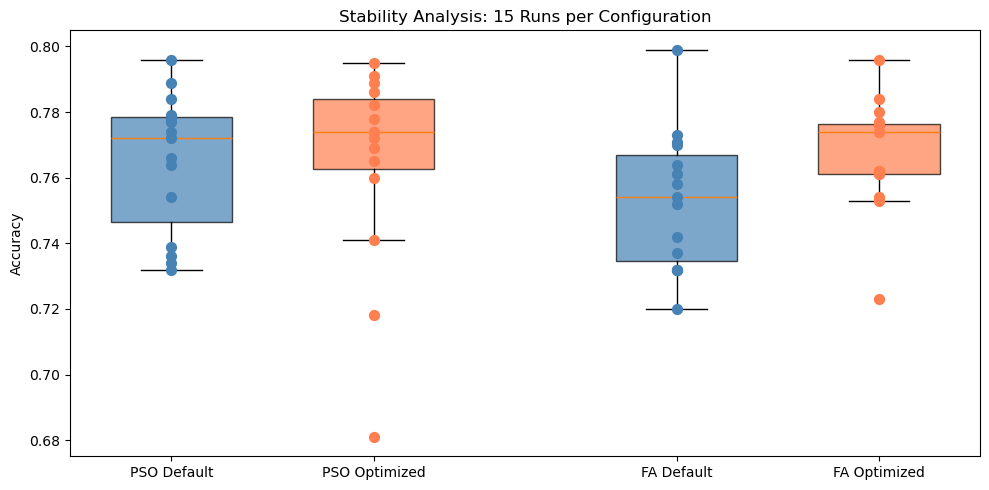

Saved: results/stability_analysis.png


In [33]:
# Stability Analysis Visualization
fig, ax = plt.subplots(figsize=(10, 5))

positions = [1, 2, 3.5, 4.5]
labels = ["PSO Default", "PSO Optimized", "FA Default", "FA Optimized"]
data = [stability_results["PSO_default"], stability_results["PSO_optimized"],
        stability_results["FA_default"], stability_results["FA_optimized"]]

bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
colors = ['steelblue', 'coral', 'steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Fix: use actual length of each list
n_runs = len(stability_results["PSO_default"])
ax.scatter([positions[0]]*n_runs, stability_results["PSO_default"], c='steelblue', s=50, zorder=5)
ax.scatter([positions[1]]*n_runs, stability_results["PSO_optimized"], c='coral', s=50, zorder=5)
ax.scatter([positions[2]]*n_runs, stability_results["FA_default"], c='steelblue', s=50, zorder=5)
ax.scatter([positions[3]]*n_runs, stability_results["FA_optimized"], c='coral', s=50, zorder=5)

ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy")
ax.set_title(f"Stability Analysis: {n_runs} Runs per Configuration")

plt.tight_layout()
plt.savefig("results/stability_analysis.png", dpi=150)
plt.show()
print("Saved: results/stability_analysis.png")

In [34]:
# Save runtime summary
runtime_df = pd.DataFrame({
    "Stage": ["PSO Tuning (GWO)", "Firefly Tuning (GWO)", "PSO Final Training", "FA Final Training"],
    "Time_seconds": [pso_tuning_time, fa_tuning_time, 
                     sum([h.get('train_time', 0) for h in [pso_history]]) if isinstance(pso_history, dict) else 0,
                     sum([h.get('train_time', 0) for h in [fa_history]]) if isinstance(fa_history, dict) else 0]
})
runtime_df.to_csv("results/runtime_summary.csv", index=False)
print("Saved: results/runtime_summary.csv")
print(f"\nPSO Tuning: {pso_tuning_time:.2f}s ({pso_tuning_time/60:.1f} min)")
print(f"FA Tuning: {fa_tuning_time:.2f}s ({fa_tuning_time/60:.1f} min)")

Saved: results/runtime_summary.csv

PSO Tuning: 3000.36s (50.0 min)
FA Tuning: 4013.58s (66.9 min)


In [35]:
print("\n" + "="*50)
print("NOTEBOOK COMPLETE!")
print("="*50)
print(f"\nTotal tuning time for PSO: {pso_tuning_time:.2f}s")
print(f"Total tuning time for FA: {fa_tuning_time:.2f}s")
print(f"\nFiles saved in results/:")
print("  - tuning_comparison.csv")
print("  - delta_performance.csv")
print("  - training_history.csv")
print("  - stability_log.csv")
print("  - best_pso_model.pt")
print("  - best_fa_model.pt")
print("  - final_test.json")
print("  - optimization_results.png")
print("  - stability_analysis.png")


NOTEBOOK COMPLETE!

Total tuning time for PSO: 3000.36s
Total tuning time for FA: 4013.58s

Files saved in results/:
  - tuning_comparison.csv
  - delta_performance.csv
  - training_history.csv
  - stability_log.csv
  - best_pso_model.pt
  - best_fa_model.pt
  - final_test.json
  - optimization_results.png
  - stability_analysis.png
